In [1]:
import sys
import pathlib
import pickle
from sklearn.cluster import MiniBatchKMeans, KMeans

In [2]:
sys.path.insert(0, "src")
import data_functions
import embedding_functions
import cluster_functions
import util_functions

C:\Users\fra3066mat\appdata\Local\miniconda3\envs\concept-graphs\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


C:\Users\fra3066mat\appdata\Local\miniconda3\envs\concept-graphs\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\fra3066mat\appdata\Local\miniconda3\envs\concept-graphs\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
C:\Users\fra3066mat\appdata\Loca

In [3]:
grascco_data = data_functions.DataProcessingFactory.load(
    pathlib.Path("./tmp/grascco/grascco_data.pickle")
)

In [4]:
grascco_embedding = embedding_functions.SentenceEmbeddingsFactory.load(
    pathlib.Path("./tmp/grascco/grascco_data.pickle"),
    pathlib.Path("./tmp/grascco/grascco_embedding.pickle")
)

In [5]:
#_clustering_cache = pathlib.Path("./tmp/test_grascco_cluster_cache.pickle")
# grascco_cluster = cluster_functions.PhraseClusterFactory.create(
#     sentence_embeddings=grascco_embedding,
#     cache_path=_clustering_cache,
#     cache_name="grascco",
#     cluster_algorithm="kmeans",
#     # kelbow_metric="silhouette",
#     kelbow_k=(10,50),
#     kelbow_estimator="kmeans-mb",
# )

---

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.utils.random import sample_without_replacement
from sklearn.linear_model import LinearRegression
from umap import UMAP
from yellowbrick.cluster import kelbow_visualizer

In [7]:
def fit_regression(x_reg, y_reg, degree=3):
    poly = PolynomialFeatures(degree=degree)
    x_poly = poly.fit_transform(np.asarray(x_reg).reshape(-1,1))

    model = LinearRegression()
    model.fit(x_poly, np.asarray(y_reg))
    
    x_lin = np.linspace(np.asarray(x_reg).min(), np.asarray(x_reg).max(), 100)
    x_out = poly.transform(x_lin.reshape(-1,1))
    y_out = model.predict(x_out)
    max_reg = np.asarray(x_reg)[np.argmax(y_out)]
    
    return x_lin, y_out, max_reg

In [8]:
_umap_params = {'n_neighbors': 50, 'metric':'cosine', 'min_dist':0.0,}
umap = UMAP(n_components=2, **_umap_params)
projection_umap_vis = umap.fit_transform(grascco_embedding.sentence_embeddings)
umap = UMAP(n_components=100, **_umap_params)
projection_umap_calc = umap.fit_transform(grascco_embedding.sentence_embeddings)

In [9]:
n_samples = 15
sample_fraction = 25
samples = []
for i in range(n_samples):
    samples.append(sample_without_replacement(projection_umap_vis.shape[0], int(projection_umap_vis.shape[0]/sample_fraction)))
mms = MinMaxScaler().fit(projection_umap_vis)

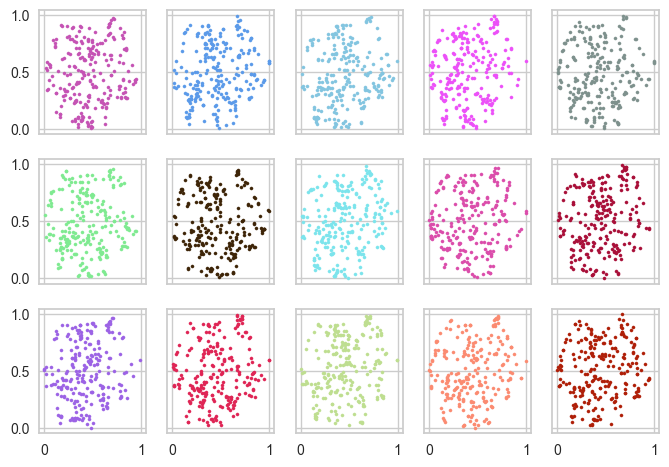

In [10]:
i = 0
_, axs = plt.subplots(3,5, sharex=True, sharey=True)
for _c in np.random.rand(n_samples,3):
    x = i%3
    y = i%5
    axs[x,y].scatter(*mms.transform(projection_umap_vis[samples[i]]).T, s=5, color=_c)
    i += 1
plt.show()

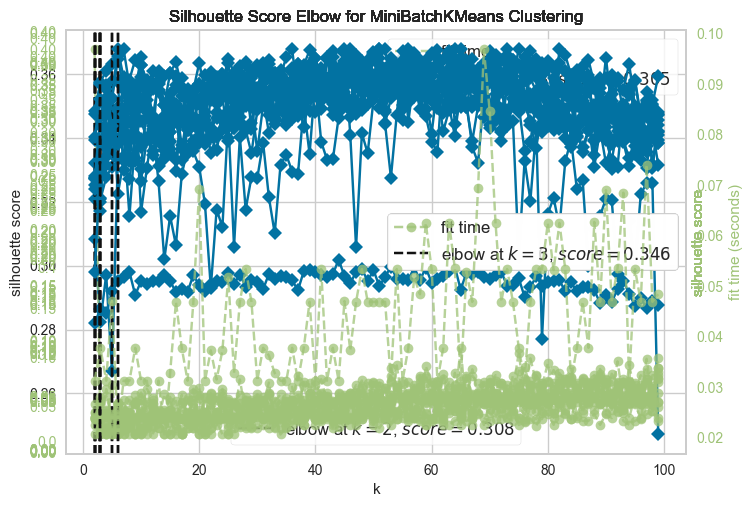

In [11]:
kelbow = []
for _sample in samples:
    _kelbow = kelbow_visualizer(
        model=MiniBatchKMeans(n_init='auto'),
        X=projection_umap_calc[_sample],
        show=False,
        k=(2,100),
        metric='silhouette'
    )
    kelbow.append(_kelbow)


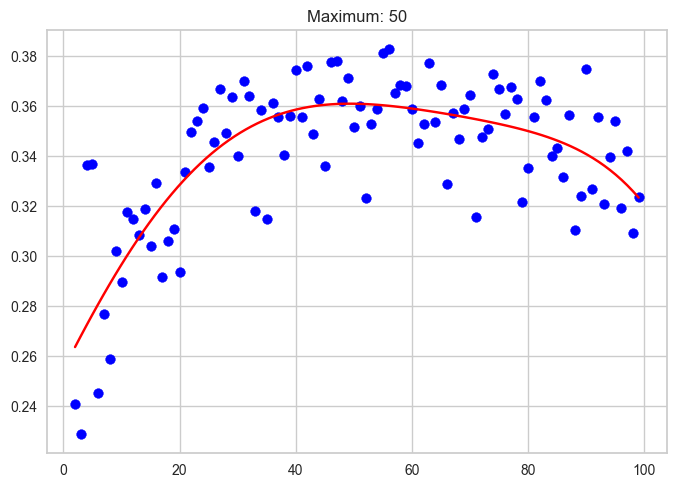

In [12]:
kelbow_val = kelbow[2]

x_vals, y_regression, max_regression = fit_regression(kelbow_val.k_values_, kelbow_val.k_scores_, 5)
plt.scatter(np.asarray(kelbow_val.k_values_).reshape(-1,1), np.asarray(kelbow_val.k_scores_), color='blue')
plt.plot(x_vals, y_regression, color='red')
plt.title(f"Maximum: {max_regression}")
plt.show()

In [13]:
_elbow_max = []
for _kelbow in kelbow:
    x_vals, y_regression, max_regression = fit_regression(_kelbow.k_values_, _kelbow.k_scores_, 5)
    _elbow_max.append(max_regression)

In [14]:
np.median(np.asarray(_elbow_max))

61.0

In [15]:
np.average(np.asarray(_elbow_max))

53.86666666666667

In [16]:
np.mean(np.asarray(_elbow_max))

53.86666666666667

In [35]:
_clustering_cache = pathlib.Path("./tmp/test_grascco_cluster_cache.pickle")
grascco_cluster = cluster_functions.PhraseClusterFactory.create(
    sentence_embeddings=grascco_embedding,
    cache_path=_clustering_cache,
    cache_name="grascco",
    cluster_by_down_scale=False,
    cluster_algorithm="kmeans",
    cluster_n_clusters=int(np.average(_elbow_max)),
    scaling_n_neighbors=50,
    scaling_metric='cosine',
    scaling_n_components=100,
    scaling_min_dist=0.0,
    kelbow_estimator=None
)

INFO:root:Building Concept Cluster ...
INFO:root:-- Clustering ...
INFO:root: (kmeans) with Arguments: {'n_clusters': 53}
C:\Users\fra3066mat\appdata\Local\miniconda3\envs\concept-graphs\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Saved under: C:\Users\fra3066mat\PycharmProjects\concept-graphs\tmp\test_grascco_cluster_cache.pickle\grascco.pickle


In [33]:
grascco_embedding.sentence_embeddings.shape

(5965, 1024)

In [36]:
list(embedding_functions.show_top_k_for_concepts(
    grascco_cluster.concept_cluster,
    grascco_embedding
))

==Center 0==

	gelenknorpel
	osteoplastischer trepanation
	acromio-claviculargelenk
	laterale claviculafraktur
	knöchern
	lateraler claviculafraktur
	kniedistorsion
	gelenken
	osteochondrose
	großbogige flexible li.-konvexe thoracolumbale skoliose
	hws- handgelenksfraktur
	mrt knie
	sprunggelenk
	knorpelgättung
	bestehenden lumbalgien


==Center 1==

	untersuchungsbefund
	befundbesprechung
	durchgeführten ausführlichen diagnostikk
	durchgeführte diagnostik
	befundkontrolle
	klinischer untersuchungsbefund
	untersuchung
	aktuelle anamnese
	diagnostik
	befundzusammenfassung
	körperliche untersuchung
	klinischen befund
	körperlichen untersuchung
	durchgeführte untersuchungen
	untersuchungen


==Center 2==

	- - mg amlodipin
	- - mg ramipril
	mg p.o .
	tambocor mg
	promethazin mg
	mg 1xtgl
	mg
	pantolok mg
	mg risperdal
	e mg
	pantoloc mg
	- - mg
	mg bolus
	mg levetiracetam
	mg - - -


==Center 3==

	( lymphknotenmeta
	hämatome
	peripherer lymphknotenstatus
	hämatom
	flächiges subkutanes hä

[]